In [1]:
import numpy as np
import pandas as pd

In [2]:
import re
import datetime
import calendar

# Report Data

In [3]:
raw_df = pd.read_csv('data/report_scrape/report_text.csv')
raw_df.set_index('report_id', inplace=True)
raw_df.head()

,datetime,city,state,shape,duration,post_date,report_text
report_id,,,,,,,
073/S73909,1/1/10 00:00,Park City,KY,Light,2-3 seconds,2/14/10,"Lights orbiting the moon,I am 10,and i was wit..."
073/S73977,1/1/10,Glasgow (UK/Scotland),NaN,Fireball,2 minutes,2/14/10,"Bright orange, glowing orb came towards us. I..."
073/S73915,1/1/10 00:00,La Mesa,CA,Light,10 min,2/14/10,Three red lights over southern California that...
078/S78231,1/1/10 00:00,Benton,AR,Circle,5 mins.,11/21/10,4 bright green circles high in the sky going i...
073/S73918,1/1/10 00:00,El Cajon,CA,Triangle,12 minutes,2/14/10,"3 Red objects hovering over El Cajon CA ,Exit..."


# Duplicate Reports

In [4]:
# number of duplicate reports
raw_df.duplicated().sum()

7841

In [5]:
# remove duplicates
raw_df.drop_duplicates(inplace=True)

In [6]:
len(raw_df)

61891

In [7]:
ufo_df = raw_df.copy()

In [8]:
len(ufo_df)

61891

# Report Text
- Missing Text
- MADAR

## Missing Text

In [9]:
# number of reports missing text
ufo_df['report_text'].isna().sum()

51

In [10]:
# drop reports missing text
ufo_df.dropna(subset=['report_text'], inplace=True)

## MADAR
Remove "MADAR Node" reports

In [11]:
# number of MADAR reports
ufo_df['report_text'].str.startswith('MADAR').sum()

710

In [12]:
# filter out MADAR reports
ufo_df = ufo_df[~ufo_df['report_text'].str.startswith('MADAR')]

# Shape

## nans
fill NaNs with "Unknown"

In [13]:
# shape types
ufo_df['shape'].unique()

array(['Light', 'Fireball', 'Circle', 'Triangle', 'Unknown', 'Formation',
       'Other', 'Sphere', 'Diamond', 'Oval', 'Disk', 'Chevron', nan,
       'Changing', 'Rectangle', 'Cross', 'Flash', 'Cigar', 'Teardrop',
       'Cylinder', 'Egg', 'Cone', 'TRIANGULAR'], dtype=object)

In [14]:
# number of reports missing shape
ufo_df['shape'].isna().sum()

1163

In [15]:
# replace nans with unknown
ufo_df['shape'] = ufo_df['shape'].replace(float('NaN'), 'Unknown')

# Location 
- Drop Missing
- Geolocation Filtering
- Assign Regions

## Drop Missing

In [16]:
# number of reports missing city locations
ufo_df['city'].isna().sum()

113

In [17]:
# drop reports without city location
ufo_df.dropna(subset=['city'], inplace=True)

## Geolocation Filter
- Retrieve US geolocations from simplemaps using coordinates:
https://simplemaps.com/data/us-cities
- Filter only incorporated, US communities

In [18]:
# add geolocation
ufo_df['geolocation'] = ufo_df['city'] + ', ' + ufo_df['state']

In [19]:
# read in city coordinates dataframe
geo_cities = pd.read_csv('data/simplemaps_uscities_basicv1.6/uscities_2019-09.csv', 
                         usecols=['city', 'state_id'])
# list of cities
geo_locs = geo_cities['city'] + ', ' + geo_cities['state_id']

In [20]:
# number of reports in unincorporated communities
len(ufo_df) - ufo_df['geolocation'].isin(geo_locs).sum()

15025

In [21]:
# filter only incorporated communities
ufo_df = ufo_df[ufo_df['geolocation'].isin(geo_locs)]

## Assign Regions

In [22]:
# dictinonary of US regions by state abbreviation
us_divisions = {
    'CT': 'New England', 'ME': 'New England', 'MA': 'New England', 
    'NH': 'New England', 'RI': 'New England', 'VT': 'New England',
    'NJ': 'Mid-Atlantic', 'NY': 'Mid-Atlantic', 'PA': 'Mid-Atlantic',
    'IL': 'East North Central', 'IN': 'East North Central', 'MI': 'East North Central', 
    'OH': 'East North Central', 'WI': 'East North Central',
    'IA': 'West North Central', 'KS': 'West North Central', 'MN': 'West North Central', 
    'MO': 'West North Central', 'NE': 'West North Central', 'ND': 'West North Central', 
    'SD': 'West North Central',
    'DE': 'South Atlantic', 'FL': 'South Atlantic', 'GA': 'South Atlantic', 'MD': 'South Atlantic', 
    'NC': 'South Atlantic', 'SC': 'South Atlantic', 'VA': 'South Atlantic', 'DC': 'South Atlantic', 
    'WV': 'South Atlantic',
    'AL': 'East South Central', 'KY': 'East South Central', 'MS': 'East South Central', 
    'TN': 'East South Central',
    'AR': 'West South Central', 'LA': 'West South Central', 'OK': 'West South Central', 
    'TX': 'West South Central',
    'AZ': 'Mountain', 'CO': 'Mountain', 'ID': 'Mountain', 'MT': 'Mountain', 'NV': 'Mountain', 
    'NM': 'Mountain', 'UT': 'Mountain', 'WY': 'Mountain',
    'AK': 'Pacific', 'CA': 'Pacific', 'HI': 'Pacific', 'OR': 'Pacific', 'WA': 'Pacific'
}

In [23]:
ufo_df['region'] = ufo_df['state'].apply(lambda x: us_divisions[x])

In [24]:
ufo_df.head()

,datetime,city,state,shape,duration,post_date,report_text,geolocation,region
report_id,,,,,,,,,
073/S73909,1/1/10 00:00,Park City,KY,Light,2-3 seconds,2/14/10,"Lights orbiting the moon,I am 10,and i was wit...","Park City, KY",East South Central
073/S73915,1/1/10 00:00,La Mesa,CA,Light,10 min,2/14/10,Three red lights over southern California that...,"La Mesa, CA",Pacific
078/S78231,1/1/10 00:00,Benton,AR,Circle,5 mins.,11/21/10,4 bright green circles high in the sky going i...,"Benton, AR",West South Central
073/S73918,1/1/10 00:00,El Cajon,CA,Triangle,12 minutes,2/14/10,"3 Red objects hovering over El Cajon CA ,Exit...","El Cajon, CA",Pacific
073/S73916,1/1/10 00:00,Lemon Grove,CA,Light,about 15 minutes,2/14/10,3 Red lights in line pattern above El Cajon/ E...,"Lemon Grove, CA",Pacific


# Timestamps
- Drop Missing
- Format
- Time-based Features

## Drop Missing

In [25]:
# number of reports missing timestamp
ufo_df['datetime'].isna().sum()

0

In [26]:
# drop reports without timestamp
ufo_df.dropna(subset=['datetime'], inplace=True)

In [27]:
# function to parse out time in timestamp
def return_time(date_time):
    try:
        return(date_time.split(' ')[1])
    except:
        return(None)

In [28]:
# number of reports missing time
ufo_df['datetime'].apply(lambda x: return_time(x)).isnull().sum()

312

In [29]:
# filter out reports without time
ufo_df = ufo_df[~ufo_df['datetime'].apply(lambda x: return_time(x)).isnull()]

## Format

In [30]:
# datetime formats
ufo_df['datetime'].apply(lambda x: re.sub('\d', 'X', x)).unique()

array(['X/X/XX XX:XX', 'X/XX/XX XX:XX', 'XX/X/XX XX:XX', 'XX/XX/XX XX:XX'],
      dtype=object)

In [31]:
# convert to datetime objects
ufo_df['datetime'] = pd.to_datetime(ufo_df['datetime'])

## Time-based Features

In [32]:
# extract season of timestamp
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('Winter', (datetime.date(Y,  1,  1),  datetime.date(Y,  3, 20))),
           ('Spring', (datetime.date(Y,  3, 21),  datetime.date(Y,  6, 20))),
           ('Summer', (datetime.date(Y,  6, 21),  datetime.date(Y,  9, 22))),
           ('Fall', (datetime.date(Y,  9, 23),  datetime.date(Y, 12, 20))),
           ('Winter', (datetime.date(Y, 12, 21),  datetime.date(Y, 12, 31)))]

def get_season(timestamp):
    timestamp_date = timestamp.date()
    timestamp_date = timestamp_date.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= timestamp_date <= end)

In [33]:
# seasons
ufo_df['season'] = ufo_df['datetime'].apply(get_season)

In [34]:
# extract timestamp month
ufo_df['month'] = ufo_df['datetime'].apply(lambda x: calendar.month_name[x.month])

In [35]:
# extract timestamp day of week
ufo_df['day'] = ufo_df['datetime'].apply(lambda x: calendar.day_name[x.weekday()])

In [36]:
# extract timestamp time of day category
daytimes = [('Morning', (datetime.time(6),  datetime.time(11, 59, 59))),
           ('Afternoon', (datetime.time(12),  datetime.time(17, 59, 59))),
           ('Evening', (datetime.time(18),  datetime.time(23, 59, 59))),
           ('Night', (datetime.time(0),  datetime.time(5, 59, 59)))]

def get_daytime(timestamp):
    timestamp_time = timestamp.strftime('%H:%M:%S')
    return next(daytime for daytime, (start, end) in daytimes
                if str(start) <= timestamp_time <= str(end))

In [37]:
# extract timestamp time of day
ufo_df['time_of_day'] = ufo_df['datetime'].apply(get_daytime)

In [38]:
ufo_df.head()

,datetime,city,state,shape,duration,post_date,report_text,geolocation,region,season,month,day,time_of_day
report_id,,,,,,,,,,,,,
073/S73909,2010-01-01,Park City,KY,Light,2-3 seconds,2/14/10,"Lights orbiting the moon,I am 10,and i was wit...","Park City, KY",East South Central,Winter,January,Friday,Night
073/S73915,2010-01-01,La Mesa,CA,Light,10 min,2/14/10,Three red lights over southern California that...,"La Mesa, CA",Pacific,Winter,January,Friday,Night
078/S78231,2010-01-01,Benton,AR,Circle,5 mins.,11/21/10,4 bright green circles high in the sky going i...,"Benton, AR",West South Central,Winter,January,Friday,Night
073/S73918,2010-01-01,El Cajon,CA,Triangle,12 minutes,2/14/10,"3 Red objects hovering over El Cajon CA ,Exit...","El Cajon, CA",Pacific,Winter,January,Friday,Night
073/S73916,2010-01-01,Lemon Grove,CA,Light,about 15 minutes,2/14/10,3 Red lights in line pattern above El Cajon/ E...,"Lemon Grove, CA",Pacific,Winter,January,Friday,Night


# Duration
Reformat to total seconds

In [39]:
# number of unique duration formats
ufo_df['duration'].apply(lambda x: re.sub('\d', 'X', str(x))).nunique()

2306

In [40]:
# clear colon digits
ufo_df['duration'] = ufo_df['duration'].apply(lambda x: re.sub('\:\d+', '', str(x)))

In [41]:
# function to convert duration strings to numerical values
time_dict = {'h': 3600, 'm': 60, 's': 1}

def comp_dur(rep_dur):
    # extract number-unit tuples
    prs_dur = re.findall(r'(\d+\.?\d*)+(\s*[smh])', str(rep_dur).lower())
    duration = 0
    try:
        # sum duration for all pairs
        for dur in prs_dur:
            duration += float(dur[0]) * time_dict[dur[1].strip()]
            if duration == 0:
                duration = None
            return(duration)
    except:
        return(None)

In [42]:
# run function for observations
ufo_df['duration'] = ufo_df['duration'].apply(comp_dur)

In [43]:
# number of reports with null duration
ufo_df['duration'].isnull().sum()

5399

In [44]:
# fill nulls with average duration
ufo_df['duration'].fillna(ufo_df['duration'].mean(), inplace=True)

In [45]:
ufo_df.head()

,datetime,city,state,shape,duration,post_date,report_text,geolocation,region,season,month,day,time_of_day
report_id,,,,,,,,,,,,,
073/S73909,2010-01-01,Park City,KY,Light,3.0,2/14/10,"Lights orbiting the moon,I am 10,and i was wit...","Park City, KY",East South Central,Winter,January,Friday,Night
073/S73915,2010-01-01,La Mesa,CA,Light,600.0,2/14/10,Three red lights over southern California that...,"La Mesa, CA",Pacific,Winter,January,Friday,Night
078/S78231,2010-01-01,Benton,AR,Circle,300.0,11/21/10,4 bright green circles high in the sky going i...,"Benton, AR",West South Central,Winter,January,Friday,Night
073/S73918,2010-01-01,El Cajon,CA,Triangle,720.0,2/14/10,"3 Red objects hovering over El Cajon CA ,Exit...","El Cajon, CA",Pacific,Winter,January,Friday,Night
073/S73916,2010-01-01,Lemon Grove,CA,Light,900.0,2/14/10,3 Red lights in line pattern above El Cajon/ E...,"Lemon Grove, CA",Pacific,Winter,January,Friday,Night


# Final DF
- Drop Columns
- Export DF

## Order Columns
Reorder columns and drop unneeded ones

In [46]:
# reorder columns
ufo_df = ufo_df[['datetime', 'geolocation', 'season', 'month', 'day', 
                 'time_of_day', 'region', 'shape', 'duration', 'report_text']]

In [47]:
ufo_df.head()

,datetime,geolocation,season,month,day,time_of_day,region,shape,duration,report_text
report_id,,,,,,,,,,
073/S73909,2010-01-01,"Park City, KY",Winter,January,Friday,Night,East South Central,Light,3.0,"Lights orbiting the moon,I am 10,and i was wit..."
073/S73915,2010-01-01,"La Mesa, CA",Winter,January,Friday,Night,Pacific,Light,600.0,Three red lights over southern California that...
078/S78231,2010-01-01,"Benton, AR",Winter,January,Friday,Night,West South Central,Circle,300.0,4 bright green circles high in the sky going i...
073/S73918,2010-01-01,"El Cajon, CA",Winter,January,Friday,Night,Pacific,Triangle,720.0,"3 Red objects hovering over El Cajon CA ,Exit..."
073/S73916,2010-01-01,"Lemon Grove, CA",Winter,January,Friday,Night,Pacific,Light,900.0,3 Red lights in line pattern above El Cajon/ E...


## Export DF

In [48]:
# ufo_df.to_csv('data/ufo_df.csv')

# OLD

# EDA

In [9]:
import plotly.express as px

In [13]:
raw_df.head()

,datetime,city,state,shape,duration,post_date,report_text
report_id,,,,,,,
073/S73909,1/1/10 00:00,Park City,KY,Light,2-3 seconds,2/14/10,"Lights orbiting the moon,I am 10,and i was wit..."
073/S73977,1/1/10,Glasgow (UK/Scotland),NaN,Fireball,2 minutes,2/14/10,"Bright orange, glowing orb came towards us. I..."
073/S73915,1/1/10 00:00,La Mesa,CA,Light,10 min,2/14/10,Three red lights over southern California that...
078/S78231,1/1/10 00:00,Benton,AR,Circle,5 mins.,11/21/10,4 bright green circles high in the sky going i...
073/S73918,1/1/10 00:00,El Cajon,CA,Triangle,12 minutes,2/14/10,"3 Red objects hovering over El Cajon CA ,Exit..."


In [24]:
raw_df['datetime'] = pd.to_datetime(raw_df['datetime'])

In [28]:
raw_df.groupby([(raw_df['datetime'].dt.year),(raw_df['datetime'].dt.month)]).count()

datetime  city  state  shape  duration  post_date  \
datetime datetime                                                      
2010     1              296   296    250    289       286        296   
         2              193   193    170    188       187        193   
         3              265   263    236    258       255        265   
         4              296   295    264    290       284        296   
         5              334   334    308    327       327        334   
...                     ...   ...    ...    ...       ...        ...   
2019     8              467   467    456    419       411        467   
         9              646   640    627    565       562        646   
         10             706   702    694    630       622        706   
         11             680   674    649    596       601        680   
         12             588   586    562    495       502        588   

                   report_text  
datetime datetime               
2010     1                 296  
         2                 193  
         3                 265  
         4                 293  
         5                 334  
...                        ...  
2019     8                 467  
         9                 646  
         10                696  
         11                673  
         12                588  

[120 rows x 7 columns]

In [11]:
fig = px.scatter(x=[0, 1, 2, 3, 4], y=[0, 1, 4, 9, 16])
fig.show()

# Report Overview Data

In [51]:
counts_df = pd.read_csv('data/report_counts.csv', index_col=0)
# drop last row
counts_df.drop(counts_df.tail(1).index,inplace=True)
counts_df.head()

,Reports,Count,Link
0,09/2019,257,http://www.nuforc.org/webreports/ndxe201909.html
1,08/2019,442,http://www.nuforc.org/webreports/ndxe201908.html
2,07/2019,582,http://www.nuforc.org/webreports/ndxe201907.html
3,06/2019,463,http://www.nuforc.org/webreports/ndxe201906.html
4,05/2019,526,http://www.nuforc.org/webreports/ndxe201905.html


In [56]:
# only records from 1900 onward
counts_df = counts_df[counts_df['Reports'].str[-4:].astype('int') >= 1900]

In [58]:
# convert to datetime
counts_df['Reports'] = pd.to_datetime(counts_df['Reports'])
counts_df.head()

,Reports,Count,Link
0,2019-09-01,257,http://www.nuforc.org/webreports/ndxe201909.html
1,2019-08-01,442,http://www.nuforc.org/webreports/ndxe201908.html
2,2019-07-01,582,http://www.nuforc.org/webreports/ndxe201907.html
3,2019-06-01,463,http://www.nuforc.org/webreports/ndxe201906.html
4,2019-05-01,526,http://www.nuforc.org/webreports/ndxe201905.html


In [ ]:
from pandas.plotting import register_matplotlib_converters

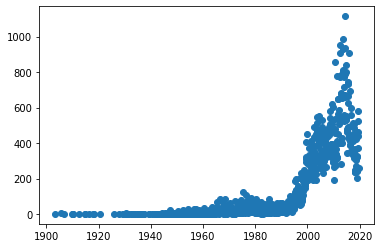

In [64]:
register_matplotlib_converters()
plt.scatter(counts_df['Reports'], counts_df['Count'])